In [26]:
#load libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [27]:
data1 = arff.loadarff('/content/drive/MyDrive/Colab Notebooks/6709_final/sample/TimeBasedFeatures-Dataset-15s-NO-VPN.arff')
title1 = 'Sample TimeBasedFeatures-15s-NO-VPN'
df = pd.DataFrame(data1[0])
df = df[['min_fiat', 'max_fiat', 'class1']]
m1 = df.loc[df['class1']==b'BROWSING']
m2 = df.loc[df['class1']==b'VOIP']
frames = [m1, m2]
df = pd.concat(frames)
df['class1'].replace([b'BROWSING', b'VOIP'], [0,1], inplace=True)
df = df.sample(n = 50, random_state=1)
df.head()

,min_fiat,max_fiat,class1
8456,15523.0,24430.0,1
1039,3.0,9700973.0,0
8339,5884.0,72881.0,1
6833,106.0,37602.0,1
440,40.0,6842275.0,0


[Text(0.5, 1.0, 'Sample TimeBasedFeatures-15s-NO-VPN')]

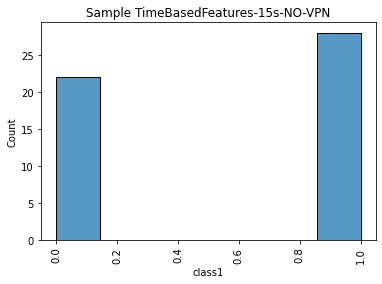

In [28]:
plt.xticks(rotation=90)
sns.histplot(data=df, x="class1").set(title=title1)
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/6709_final/scenarioA2/TimeBasedFeatures-Dataset-15s-NO-VPN.png')


In [29]:

X = df[columnNames]
y = df.class1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8


In [30]:
! pip install graphviz
! pip install pydotplus

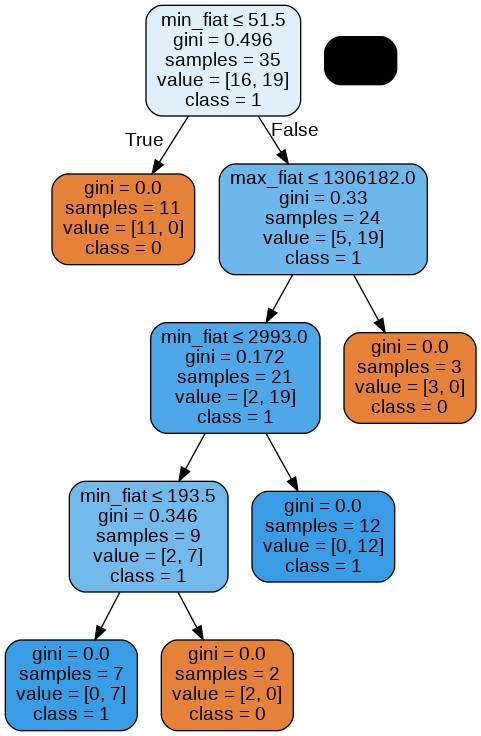

In [31]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = columnNames,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('/content/drive/MyDrive/Colab Notebooks/6709_final/sample/TREE.png')
Image(graph.create_png())

In [32]:
#infinity = clf.tree_.threshold[0]
infinity = float('inf')
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
impurity = clf.tree_.impurity
value = clf.tree_.value


#function based on 
#https://stackoverflow.com/questions/66297576/how-to-retrieve-the-full-branch-path-leading-to-each-leaf-node-of-a-sklearn-deci

def retrieve_branches(number_nodes, children_left_list, children_right_list):
    """Retrieve decision tree branches"""
    
    # Calculate if a node is a leaf
    is_leaves_list = [(False if child_left != child_right else True) \
                      for child_left, child_right \
                      in zip(children_left_list, children_right_list)]
    
    # Store the branches paths
    paths = []
    
    for i in range(number_nodes):
        if is_leaves_list[i]:
            # Search leaf node in previous paths
            end_node = [path[-1] for path in paths]

            # If it is a leave node yield the path
            if i in end_node:
                output = paths.pop(np.argwhere(i == np.array(end_node))[0][0])
                yield output

        else:
            
            # Origin and end nodes
            origin, end_l, end_r = i, children_left_list[i], children_right_list[i]

            # Iterate over previous paths to add nodes
            for index, path in enumerate(paths):
                if origin == path[-1]:
                    paths[index] = path + [end_l]
                    paths.append(path + [end_r])

            # Initialize path in first iteration
            if i == 0:
                paths.append([i, children_left[i]])
                paths.append([i, children_right[i]])

all_branches = list(retrieve_branches(n_nodes, children_left, children_right))

for i in range(len(all_branches)):
    minFeature0 = 0.00
    maxFeature0 = infinity
    maxFeature0_temp = infinity
    minFeature1 = 0.00
    maxFeature1 = infinity

    for j in range(len(all_branches[i])):

        if all_branches[i][j] in children_left:
            if feature[all_branches[i][j-1]] == 0:
                maxFeature0 = threshold[all_branches[i][j-1]]
            if feature[all_branches[i][j-1]] == 1:
                maxFeature1 = threshold[all_branches[i][j-1]]

        elif all_branches[i][j] in children_right:
            if threshold[all_branches[i][j-1]] != threshold[all_branches[0][0]]:
                if feature[all_branches[i][j-1]] == 0:
                    minFeature0 = threshold[all_branches[i][j-1]]
                if feature[all_branches[i][j-1]] == 1:
                    minFeature1 = threshold[all_branches[i][j-1]]
         
        if threshold[all_branches[i][j]] <= 0:
            if value[all_branches[i][j]][0][0] > value[all_branches[i][j]][0][1]:
                class_value = 0
            else:
                class_value = 1
        
    print("table_add decision_table class_value {min0}->{max0} {min1}->{max1} => {class_value}"\
          .format(min0=minFeature0, max0=maxFeature0, min1=minFeature1, max1=maxFeature1, class_value = class_value))


table_add decision_table class_value 0.0->51.5 0.0->inf => 0
table_add decision_table class_value 0.0->193.5 0.0->1306182.0 => 1
table_add decision_table class_value 193.5->2993.0 0.0->1306182.0 => 0
table_add decision_table class_value 2993.0->inf 0.0->1306182.0 => 1
table_add decision_table class_value 0.0->inf 1306182.0->inf => 0
